In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#install GSDMM/vaderSentiment
!pip install git+https://github.com/rwalk/gsdmm.git
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-htv9ir39
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-htv9ir39
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4601 sha256=62a0db8c5238894f59aa8903769ad50d9ef1ecb4f3afa32e5428e0e003a97663
  Stored in directory: /tmp/pip-ephem-wheel-cache-yzgqr5ni/wheels/34/65/a6/7eef67b88abae954fecd22587bd755c27b58a9ffe488d6b0de
Successfully built gsdmm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 14.9 MB/s 


In [5]:
import pandas as pd
import numpy as np
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from gsdmm import MovieGroupProcess

#filename = "AMAZON_FASHION_5.json"
filename = "/content/drive/MyDrive/Github/CSCI-5525-final-project/AMAZON_FASHION_5.json"


df = pd.read_json(path_or_buf=filename, lines=True)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#df['asin'].value_counts()

In [ ]:
#list(df[df['asin'] == 'B009MA34NY']['reviewText'])

In [6]:
import json

#filename = "/content/drive/MyDrive/Github/CSCI-5525-final-project/AMAZON_FASHION_5.json"
def load_reviews(filename):
  with open(filename) as f:
      reviews_json = f.readlines()

  reviews = []
  for review_json in reviews_json:
      review = json.loads(review_json)
      if "overall" in review and "reviewText" in review:
          reviews.append(
              {
                  "rating": review["overall"],
                  "title": review["summary"],
                  "text": review["reviewText"],
              }
          )
  return reviews

reviews = load_reviews(filename)
#df = pd.DataFrame.from_dict(reviews)

In [7]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# NMF and LDA
Adapted from [here](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html), minimal original work.

The topics are extracting nothing of note.

Further steps:

- find a product with enough reviews to be worth analyzing alone (might have to request the full dataset)
- mess around with heuristics for vectorizing terms (reducing `max_df` probably but didn't manage to get different results)
- eliminate boring reviews?

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
from sklearn.decomposition import LatentDirichletAllocation

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

product_id = 'B009MA34NY'
if product_id:
    data_samples = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
else:
    data_samples = list(map(lambda x: x['text'], reviews))[:n_samples]


for s in data_samples:

    if not isinstance(s,str):
        print(s)

In [9]:
#preprocessing
def lowercasing(data_samples):
  for idx, sample in enumerate(data_samples):
    data_samples[idx] = sample.lower()
  return data_samples

def punctuation_removal(data_samples):
#non-exhaustive; not sure if we want to treat punctuation as significant
#doesn't remove punctuation from inside words
  for i, sample in enumerate(data_samples):
    _sample = sample.split()
    for j, word in enumerate(_sample):
      _sample[j] = word.strip(" .!?@#&():;,'\/\\")
    sample = " ".join(_sample)
    data_samples[i] = sample
  return data_samples

#credit to Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(data_samples):
  wnl = WordNetLemmatizer()
  for i, sample in enumerate(data_samples):
      _sample = sample.split()
      for j, word in enumerate(_sample):
        tag = get_wordnet_pos(word)
        _sample[j] = wnl.lemmatize(word,tag)
      data_samples[i] = " ".join(_sample)
  return data_samples

data_samples = lowercasing(data_samples)
data_samples = punctuation_removal(data_samples)
data_samples = lemmatize(data_samples)

In [10]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.03, min_df=2, max_features=n_features, stop_words="english"
)
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print(tfidf.shape)

Extracting tf-idf features for NMF...
(375, 343)


In [ ]:
#len(data_samples)

In [ ]:
#print(len(tfidf_vectorizer.stop_words_))
#tfidf_vectorizer.stop_words_

In [ ]:
#tfidf_vectorizer.get_stop_words()

In [11]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)


Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


NameError: ignored

In [12]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, 
    tfidf_feature_names, 
    n_top_words, 
    "Topics in NMF model (Frobenius norm)"
)

NameError: ignored

In [13]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

NameError: ignored

In [14]:
# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


NameError: ignored

In [15]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

NameError: ignored

In [16]:
# Fit the MiniBatchNMF model
print(
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


NameError: ignored

In [17]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

NameError: ignored

In [18]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.01, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(data_samples)
tf_vectorizer.stop_words_

Extracting tf features for LDA...


{'000',
 '10',
 '100',
 '12',
 '15',
 '169lbs',
 '1st',
 '20',
 '24',
 '25',
 '30',
 '3rd',
 '3x',
 '40',
 '50',
 'abd',
 'abit',
 'able',
 'absolutely',
 'absolutly',
 'absorption',
 'accommodate',
 'accurately',
 'ache',
 'achilles',
 'activity',
 'actually',
 'adjust',
 'adjustment',
 'advice',
 'afford',
 'afraid',
 'aide',
 'airport',
 'airy',
 'allows',
 'amazing',
 'amazon',
 'ankle',
 'anymore',
 'apart',
 'arch',
 'area',
 'arose',
 'arrive',
 'artculo',
 'asics',
 'athletic',
 'attention',
 'away',
 'awesome',
 'az',
 'bag',
 'bailing',
 'band',
 'bandage',
 'barefeet',
 'barefoot',
 'barely',
 'beach',
 'beat',
 'bed',
 'believe',
 'bend',
 'best',
 'big',
 'bit',
 'black',
 'blister',
 'blood',
 'bluff',
 'boot',
 'bootcamps',
 'bought',
 'box',
 'boxier',
 'brand',
 'break',
 'breath',
 'breathe',
 'breathes',
 'bright',
 'broader',
 'btw',
 'build',
 'bulk',
 'bunion',
 'business',
 'buy',
 'cable',
 'calf',
 'cam',
 'card',
 'cardio',
 'care',
 'careful',
 'carpet',
 'ca

Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


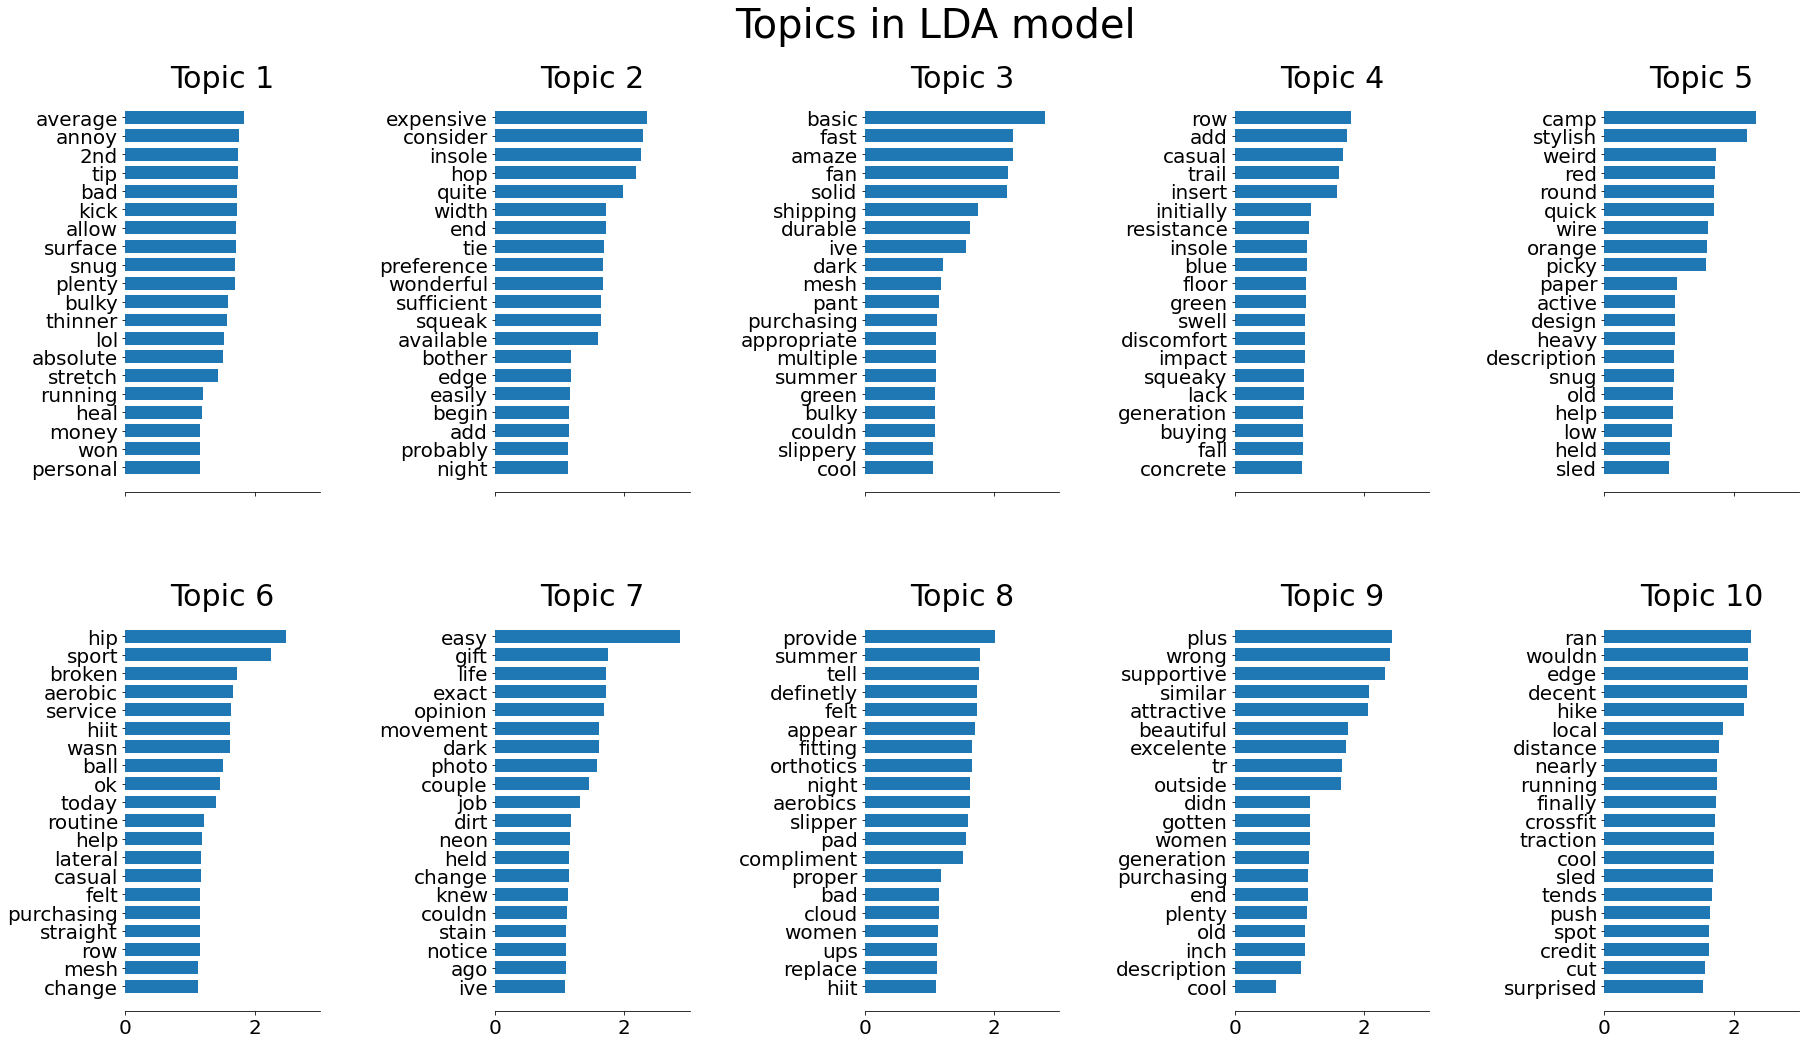

In [19]:
print(
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [20]:
for i, sample in enumerate(data_samples):
    if len(sample) > 300 and len(sample) < 700:
        print(i,":", sample)

4 : try them on in a store before buying online so i knew they'd fit good overall i be look for a durable cross training shoe that would hold up to my rigorous training and these have be great so far they be really light and comfortable most importantly for me they have grip on the bottom so my foot don't slide out from under me while do plank push-ups etc highly satisfied with this purchase
60 : glad i read the review and order a half size too big these be light weight i work out in them last night and have a great work out they be very comfortable i would recommend these to anyone i be a beach body coach and these be now my new favorite shoe to work out in i feel like i be walk in slipper when i wear these shoe they be so comfortable i love them so much i never buy myself anything nice and for christmas get an amazon gift card and use it to buy myself these sneaker and they be so awesome i really do love them and have be tell all my friend about them get these shoe
62 : i love these 

In [21]:
lda.transform(tf_vectorizer.transform([data_samples[84]]))

array([[0.01666733, 0.01666811, 0.01666765, 0.01666868, 0.01666749,
        0.84999   , 0.01666741, 0.01666835, 0.01666757, 0.01666741]])

In [22]:
data_samples[84]

"i bought these for gym training - weight class and dance class body jam zumba - and really want to like them since i love the color and the light weight feel but when i work out high impact my toe tingle go numb and cramped because the toe bed be very narrow also there wasn't enough cushion for me when do lunge the ball of my foot hurt can't return them because i wore them several time these might be fine for someone with a narrow foot"

In [23]:
from nltk import sent_tokenize
from nltk.tokenize import TweetTokenizer

raw_reviews = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))

#raw_reviews[337] were the sentences you were using prior for sentiment analysis
def get_sents(raw_reviews):
  raw_sentences = []
  for review in raw_reviews:
    raw_sentences.append(sent_tokenize(review))
  raw_sentences = sum(raw_sentences, [])

  processed_sentences = raw_sentences[:]
  processed_sentences = lowercasing(processed_sentences)
  processed_sentences = punctuation_removal(processed_sentences)
  processed_sentences = lemmatize(processed_sentences)
  return raw_sentences, processed_sentences

raw_sentences, processed_sentences = get_sents(raw_reviews)

In [24]:
#GSDMM
raw_reviews = list(map(lambda x: x['text'], reviews))[:n_samples]
raw_sentences, processed_sentences = get_sents(raw_reviews)

In [25]:
#GSDMM
tknzr = TweetTokenizer()
def get_words(sentences):
  words = []
  for sentence in sentences:
    words.append(tknzr.tokenize(sentence))
  return words

def remove_stopwords(words):
  #Just using nltk stopwords for now
  stops = set(nltk.corpus.stopwords.words('english'))
  _words = []
  for word in words:
    if word not in stops:
      _words.append(word)
  return _words

docs = get_words(processed_sentences)
for i, words in enumerate(docs):
  docs[i] = remove_stopwords(words)
  docs[i] = list(set(docs[i]))

vocab = set(x for word in words for x in word)

mgp = MovieGroupProcess(K=10, alpha=.01, beta=.01, n_iters=30)
# tutorials I saw used bigrams/trigrams for tokens in docs; might be an option for us
model = mgp.fit(docs, len(vocab))

In stage 0: transferred 4020 clusters with 10 clusters populated
In stage 1: transferred 2148 clusters with 10 clusters populated
In stage 2: transferred 1471 clusters with 10 clusters populated
In stage 3: transferred 1215 clusters with 10 clusters populated
In stage 4: transferred 1170 clusters with 10 clusters populated
In stage 5: transferred 1119 clusters with 10 clusters populated
In stage 6: transferred 1124 clusters with 10 clusters populated
In stage 7: transferred 1054 clusters with 10 clusters populated
In stage 8: transferred 1052 clusters with 10 clusters populated
In stage 9: transferred 1064 clusters with 10 clusters populated
In stage 10: transferred 1055 clusters with 10 clusters populated
In stage 11: transferred 1039 clusters with 10 clusters populated
In stage 12: transferred 999 clusters with 10 clusters populated
In stage 13: transferred 1027 clusters with 10 clusters populated
In stage 14: transferred 965 clusters with 10 clusters populated
In stage 15: transferr

In [26]:
#credit to Catherine
#https://www.kaggle.com/code/ptfrwrd/topic-modeling-guide-gsdm-lda-lsi/notebook

def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [ 383  397  365  387  525  358  391  335 1135  718]

Most important clusters (by number of docs inside): [8 9 4 1 6 3 0 2 5 7]

Cluster 8 : [('love', 401), ('shoe', 339), ('fit', 196), ('nice', 103), ('like', 87), ('great', 84), ('comfortable', 79), ('color', 74), ('pair', 63), ('look', 62)]

Cluster 9 : [('comfortable', 266), ('fit', 151), ('light', 121), ('size', 85), ('shoe', 81), ('perfect', 66), ('weight', 64), ('super', 56), ('great', 48), ('cute', 48)]

Cluster 4 : [('shoe', 143), ('good', 101), ('great', 91), ('use', 85), ('comfortable', 51), ('gym', 46), ('support', 43), ('sneaker', 40), ('workout', 37), ('perfect', 37)]

Cluster 1 : [('shoe', 122), ('foot', 68), ('size', 57), ('look', 50), ('great', 46), ('fit', 45), ('like', 38), ('always', 34), ('love', 33), ('get', 33)]

Cluster 6 : [('shoe', 115), ('comfortable', 89), ('foot', 53), ('look', 52), ('good', 40), ('great', 39), ('wear', 37), ('feel', 37), ('fit', 36), ('make', 31)]

Cluster 3 :

In [ ]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])

In [ ]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# TODO: for now compound (a composite score) will suffice. Neutrality (neu) might suggest highly informational content.
#Had to change some of the sentence processing code so the sentences were't limited
#in that code block. I limited the sentences here for endless print statment reasons
for raw, processed in zip(raw_sentences[:20], processed_sentences[:20]):
    vs = analyzer.polarity_scores(raw)
    probs = lda.transform(tf_vectorizer.transform([processed]))[0]
    topic = probs.argmax()
    if probs[topic] < 0.2:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, No Topic\n".format(raw, vs['compound'], vs['neu']))
    else:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, Topic {}: {}\n".format(raw, vs['compound'], vs['neu'], topic+1, ", ".join(topic_words[topic])))

Great product and price! 
	 overall: 0.66 neutral: 0.41, No Topic

Great product and price! 
	 overall: 0.66 neutral: 0.41, No Topic

Great product and price! 
	 overall: 0.66 neutral: 0.41, No Topic

Great product and price! 
	 overall: 0.66 neutral: 0.41, No Topic

Great product and price! 
	 overall: 0.66 neutral: 0.41, No Topic

Waaay too small. 
	 overall: 0.00 neutral: 1.00, No Topic

Will use for futur children! 
	 overall: 0.00 neutral: 1.00, No Topic

Stays vibrant after many washes 
	 overall: 0.53 neutral: 0.54, No Topic

Stays vibrant after many washes 
	 overall: 0.53 neutral: 0.54, No Topic

My son really likes the pink. 
	 overall: 0.48 neutral: 0.62, No Topic

Ones which I was nervous about 
	 overall: -0.27 neutral: 0.70, No Topic

Waaay too small. 
	 overall: 0.00 neutral: 1.00, No Topic

Will use for future child. 
	 overall: 0.00 neutral: 1.00, No Topic

Relieved my Plantar Fascitis for 3 Days. 
	 overall: 0.38 neutral: 0.70, No Topic

Then the unbearable pain retur

In [ ]:
lda.transform(tf_vectorizer.transform(["easy gift life"])).argmax()
topic_words[6]

['easy',
 'gift',
 'life',
 'exact',
 'opinion',
 'movement',
 'dark',
 'photo',
 'couple',
 'job']